In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("C:\\Users\\Sarrang\\kepler\\df.csv")

In [4]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

## Splitting the dataset into the Training set and Test set

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

## Feature Scaling

In [6]:
"""feature scaling all except'kepoi_name' and 'koi_tce_delivname'"""

"feature scaling all except'kepoi_name' and 'koi_tce_delivname'"

In [7]:
from scipy.stats import boxcox
columns_to_transform = ['koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact',
       'koi_impact_err1', 'koi_impact_err2', 'koi_duration',
       'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1',
       'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2',
       'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1',
       'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2',
       'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag']

for column in columns_to_transform:
    X_train[column] = X_train[column] - X_train[column].min() + 1
    X_train[column], _ = boxcox(X_train[column])


### standardizing to bring into same range

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

In [21]:
from joblib import dump

### Xgboost hyperparameter tuning

In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5]
}
xgb_classifier = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, 
                           cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_score)

best_xgb_model = grid_search.best_estimator_

test_accuracy = best_xgb_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)
dump(best_xgb_model, 'xgb_kepler.joblib')


Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200}
Best Accuracy: 0.9926807631391334
Test Accuracy: 0.9864087820177732


['xgb_kepler.joblib']

In [17]:
from joblib import load
xgb=load("C:\\Users\\Sarrang\\kepler\\saved joblib models\\xgb_kepler.joblib")
#retraining
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [18]:
y_pred=xgb.predict(X_test)

### model metrics

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       965
           1       0.98      1.00      0.99       948

    accuracy                           0.99      1913
   macro avg       0.99      0.99      0.99      1913
weighted avg       0.99      0.99      0.99      1913



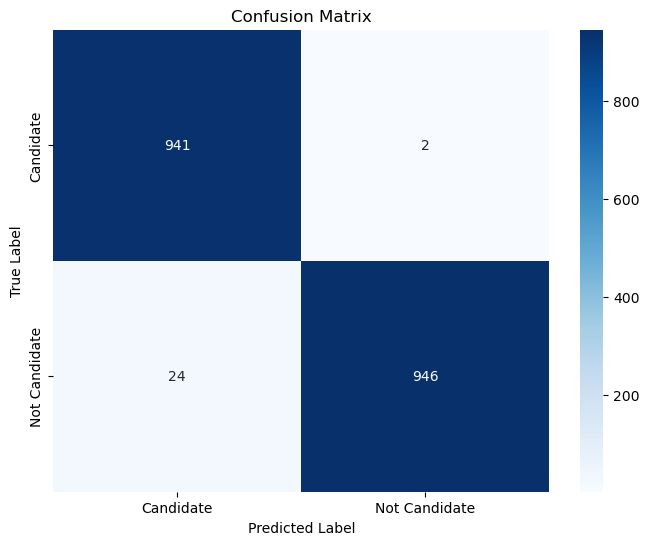

In [19]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_pred,y_test))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Candidate', 'Not Candidate'],
            yticklabels=['Candidate', 'Not Candidate'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

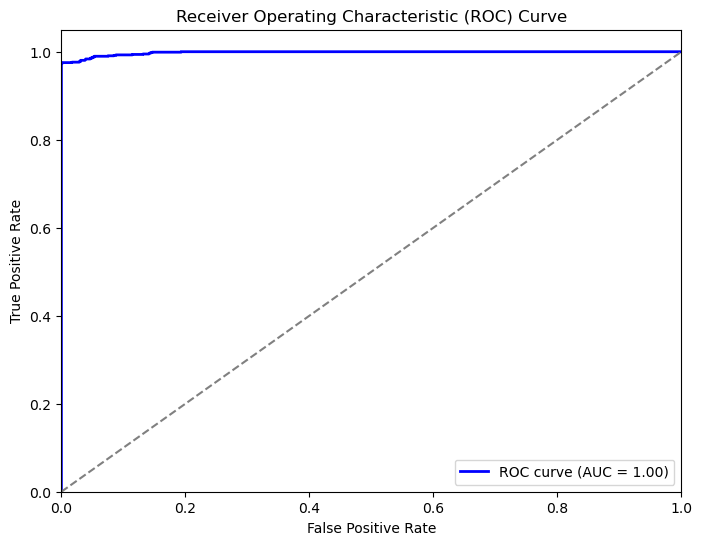

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = xgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])  # Assuming y_test is binary
auc_roc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [21]:
print(auc_roc)

0.9981283685539679
